# Clasificación de Plantas con MobileNetV3

Modelo super ligero (~2.5M params) - perfecto para este dataset pequeño

## Setup

In [ ]:
!pip install torch torchvision timm pillow matplotlib numpy scikit-learn seaborn --quiet

In [ ]:
import os
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
from torchvision.datasets import ImageFolder
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import timm
from sklearn.metrics import confusion_matrix, classification_report, precision_recall_fscore_support, roc_curve, auc
from sklearn.preprocessing import label_binarize
import seaborn as sns

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device: {device}")

Device: cuda


## Montar Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Configuración

In [ ]:
DATA_PATH = '/content/drive/MyDrive/data_balanced'
CLASSES = ['manzana', 'patatas', 'rosas']
BATCH_SIZE = 32

if os.path.exists(DATA_PATH):
    print(f"✓ Dataset encontrado: {os.listdir(DATA_PATH)}")

✓ Dataset encontrado: ['patatas', 'rosas', 'manzana']


## Transformaciones

In [ ]:
train_tfm = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(25),
    transforms.ColorJitter(0.2, 0.2, 0.2),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

test_tfm = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

## Dataset

In [ ]:
class SubsetWithTransform(Dataset):
    def __init__(self, subset, dataset, tfm):
        self.subset = list(subset)
        self.dataset = dataset
        self.tfm = tfm

    def __len__(self):
        return len(self.subset)

    def __getitem__(self, i):
        idx = self.subset[i]
        path, label = self.dataset.samples[idx]
        img = Image.open(path).convert('RGB')
        if self.tfm:
            img = self.tfm(img)
        return img, label

In [ ]:
full_ds = ImageFolder(DATA_PATH)
total = len(full_ds)
train_sz = int(0.7 * total)
val_sz = int(0.15 * total)
test_sz = total - train_sz - val_sz

print(f"Total: {total} | Train: {train_sz} | Val: {val_sz} | Test: {test_sz}")

gen = torch.Generator().manual_seed(42)
train_idx, val_idx, test_idx = random_split(range(total), [train_sz, val_sz, test_sz], generator=gen)

train_ds = SubsetWithTransform(train_idx, full_ds, train_tfm)
val_ds = SubsetWithTransform(val_idx, full_ds, test_tfm)
test_ds = SubsetWithTransform(test_idx, full_ds, test_tfm)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)
test_loader = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

Total: 2400 | Train: 1680 | Val: 360 | Test: 360


## Modelo

In [ ]:
model = timm.create_model('mobilenetv3_small_100.lamb_in1k', pretrained=True, num_classes=len(CLASSES))

# congelar todo menos el clasificador
for param in model.parameters():
    param.requires_grad = False
for param in model.classifier.parameters():
    param.requires_grad = True

model = model.to(device)
total_p = sum(p.numel() for p in model.parameters())
train_p = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Params: {total_p:,} | Trainable: {train_p:,}")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/10.2M [00:00<?, ?B/s]

Params: 1,520,931 | Trainable: 3,075


## Funciones de Training

In [ ]:
def train_epoch(model, loader, crit, opt, dev):
    model.train()
    loss_sum, correct, total = 0, 0, 0

    for x, y in loader:
        x, y = x.to(dev), y.to(dev)
        opt.zero_grad()
        out = model(x)
        loss = crit(out, y)
        loss.backward()
        opt.step()

        loss_sum += loss.item()
        correct += (out.argmax(1) == y).sum().item()
        total += y.size(0)

    return loss_sum/len(loader), 100*correct/total

def eval_model(model, loader, crit, dev):
    model.eval()
    loss_sum, correct, total = 0, 0, 0

    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(dev), y.to(dev)
            out = model(x)
            loss = crit(out, y)
            loss_sum += loss.item()
            correct += (out.argmax(1) == y).sum().item()
            total += y.size(0)

    return loss_sum/len(loader), 100*correct/total

## Fase 1: Entrenando solo el clasificador

In [ ]:
print("--- Fase 1: entrenando clasificador ---")
opt = torch.optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-3)
crit = nn.CrossEntropyLoss()
sched = torch.optim.lr_scheduler.CosineAnnealingLR(opt, T_max=5)

history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}

for ep in range(5):
    tr_loss, tr_acc = train_epoch(model, train_loader, crit, opt, device)
    val_loss, val_acc = eval_model(model, val_loader, crit, device)
    sched.step()

    history['train_loss'].append(tr_loss)
    history['train_acc'].append(tr_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)

    print(f"Epoch {ep+1}/5 - Train: {tr_acc:.2f}% | Val: {val_acc:.2f}%")

--- Fase 1: entrenando clasificador ---
Epoch 1/5 - Train: 50.06% | Val: 68.06%
Epoch 2/5 - Train: 70.95% | Val: 78.06%
Epoch 3/5 - Train: 79.70% | Val: 85.00%
Epoch 4/5 - Train: 84.58% | Val: 86.11%
Epoch 5/5 - Train: 84.64% | Val: 85.83%


## Fase 2: Fine-tuning completo

In [ ]:
print("--- Fase 2: fine-tuning completo ---")
for param in model.parameters():
    param.requires_grad = True

# lr un poco más bajo que efficientnet porque mobilenet es más sensible
opt = torch.optim.AdamW(model.parameters(), lr=8e-6)
sched = torch.optim.lr_scheduler.CosineAnnealingLR(opt, T_max=10)

best_acc = 0
for ep in range(10):
    tr_loss, tr_acc = train_epoch(model, train_loader, crit, opt, device)
    val_loss, val_acc = eval_model(model, val_loader, crit, device)
    sched.step()

    history['train_loss'].append(tr_loss)
    history['train_acc'].append(tr_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)

    if val_acc > best_acc:
        best_acc = val_acc
        torch.save(model.state_dict(), 'best_model.pth')
        print(f"Epoch {ep+1}/10 - Train: {tr_acc:.2f}% | Val: {val_acc:.2f}% ✓")
    else:
        print(f"Epoch {ep+1}/10 - Train: {tr_acc:.2f}% | Val: {val_acc:.2f}%")

--- Fase 2: fine-tuning completo ---
Epoch 1/10 - Train: 91.13% | Val: 93.06% ✓
Epoch 2/10 - Train: 95.89% | Val: 96.39% ✓
Epoch 3/10 - Train: 97.62% | Val: 96.67% ✓
Epoch 4/10 - Train: 98.21% | Val: 97.22% ✓
Epoch 5/10 - Train: 98.51% | Val: 97.22%
Epoch 6/10 - Train: 98.63% | Val: 97.50% ✓
Epoch 7/10 - Train: 98.39% | Val: 98.06% ✓
Epoch 8/10 - Train: 99.05% | Val: 98.06%
Epoch 9/10 - Train: 98.69% | Val: 98.61% ✓
Epoch 10/10 - Train: 98.93% | Val: 98.06%


## Evaluación en Test

In [ ]:
model.load_state_dict(torch.load('best_model.pth'))
test_loss, test_acc = eval_model(model, test_loader, crit, device)
print(f"\n=== Test Accuracy: {test_acc:.2f}% ===")


=== Test Accuracy: 96.39% ===


## Visualización 1: Curvas de Entrenamiento

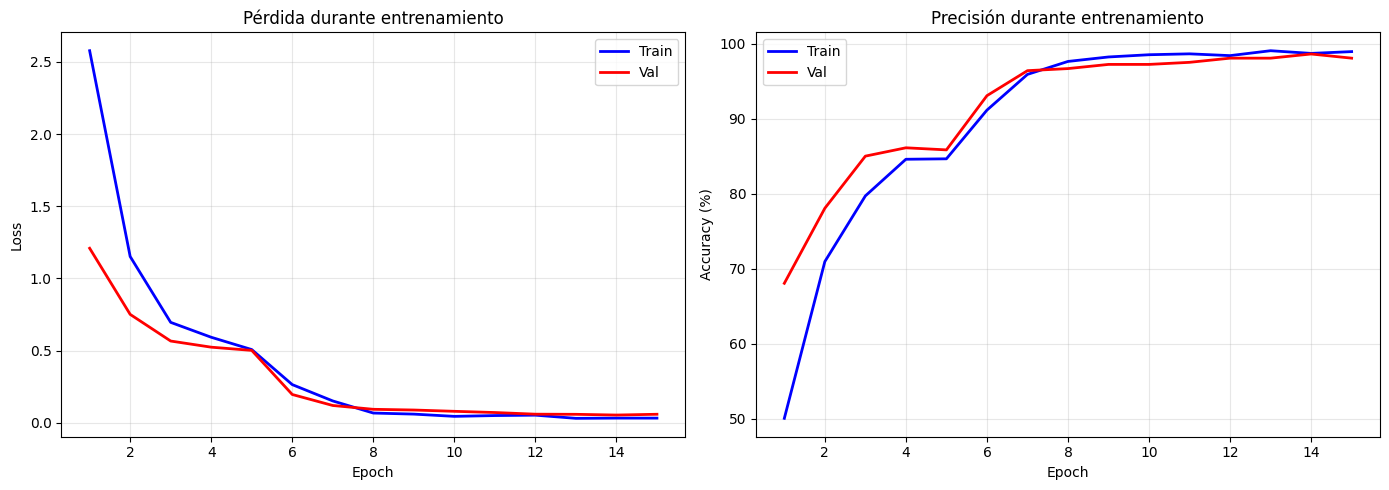

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

epochs = range(1, len(history['train_loss'])+1)
ax1.plot(epochs, history['train_loss'], 'b-', label='Train', linewidth=2)
ax1.plot(epochs, history['val_loss'], 'r-', label='Val', linewidth=2)
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('Pérdida durante entrenamiento')
ax1.legend()
ax1.grid(alpha=0.3)

ax2.plot(epochs, history['train_acc'], 'b-', label='Train', linewidth=2)
ax2.plot(epochs, history['val_acc'], 'r-', label='Val', linewidth=2)
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy (%)')
ax2.set_title('Precisión durante entrenamiento')
ax2.legend()
ax2.grid(alpha=0.3)

plt.tight_layout()
plt.savefig('training_curves_mobilenet.png', dpi=150, bbox_inches='tight')
plt.show()

## Obtener Predicciones

In [ ]:
def get_predictions(model, loader, dev):
    model.eval()
    preds, labels, probs = [], [], []

    with torch.no_grad():
        for x, y in loader:
            x = x.to(dev)
            out = model(x)
            prob = torch.softmax(out, dim=1)

            probs.extend(prob.cpu().numpy())
            preds.extend(out.argmax(1).cpu().numpy())
            labels.extend(y.numpy())

    return np.array(preds), np.array(labels), np.array(probs)

y_pred, y_true, y_prob = get_predictions(model, test_loader, device)

## Visualización 2: Matriz de Confusión

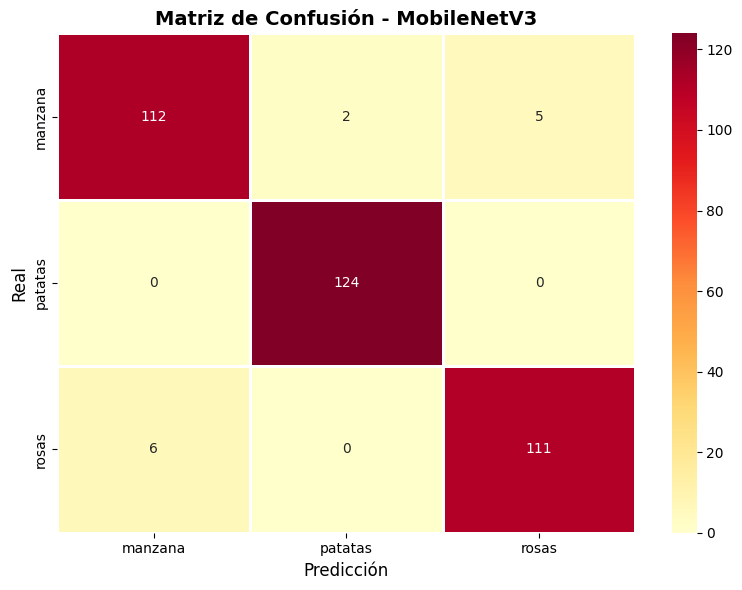

In [ ]:
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='YlOrRd',
            xticklabels=CLASSES, yticklabels=CLASSES,
            linewidths=1, linecolor='white')
plt.xlabel('Predicción', fontsize=12)
plt.ylabel('Real', fontsize=12)
plt.title('Matriz de Confusión - MobileNetV3', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('confusion_matrix_mobilenet.png', dpi=150, bbox_inches='tight')
plt.show()

## Visualización 3: Métricas por Clase

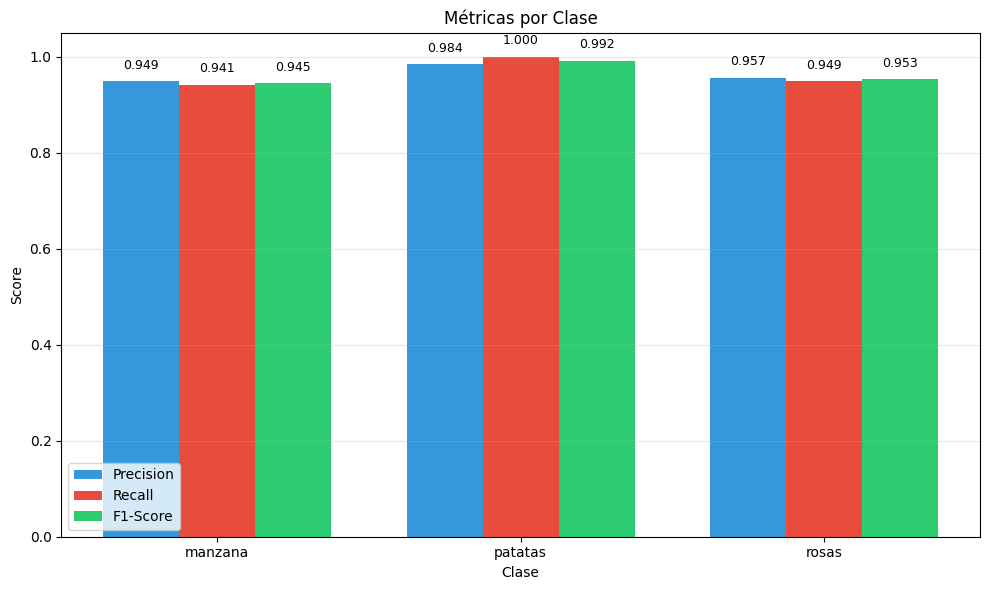

In [ ]:
precision, recall, f1, support = precision_recall_fscore_support(y_true, y_pred, average=None)

fig, ax = plt.subplots(figsize=(10, 6))
x = np.arange(len(CLASSES))
width = 0.25

ax.bar(x - width, precision, width, label='Precision', color='#3498db')
ax.bar(x, recall, width, label='Recall', color='#e74c3c')
ax.bar(x + width, f1, width, label='F1-Score', color='#2ecc71')

ax.set_xlabel('Clase')
ax.set_ylabel('Score')
ax.set_title('Métricas por Clase')
ax.set_xticks(x)
ax.set_xticklabels(CLASSES)
ax.legend()
ax.grid(axis='y', alpha=0.3)
ax.set_ylim([0, 1.05])

for i, v in enumerate(precision):
    ax.text(i - width, v + 0.02, f'{v:.3f}', ha='center', va='bottom', fontsize=9)
for i, v in enumerate(recall):
    ax.text(i, v + 0.02, f'{v:.3f}', ha='center', va='bottom', fontsize=9)
for i, v in enumerate(f1):
    ax.text(i + width, v + 0.02, f'{v:.3f}', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.savefig('metrics_per_class_mobilenet.png', dpi=150, bbox_inches='tight')
plt.show()

## Visualización 4: Curvas ROC

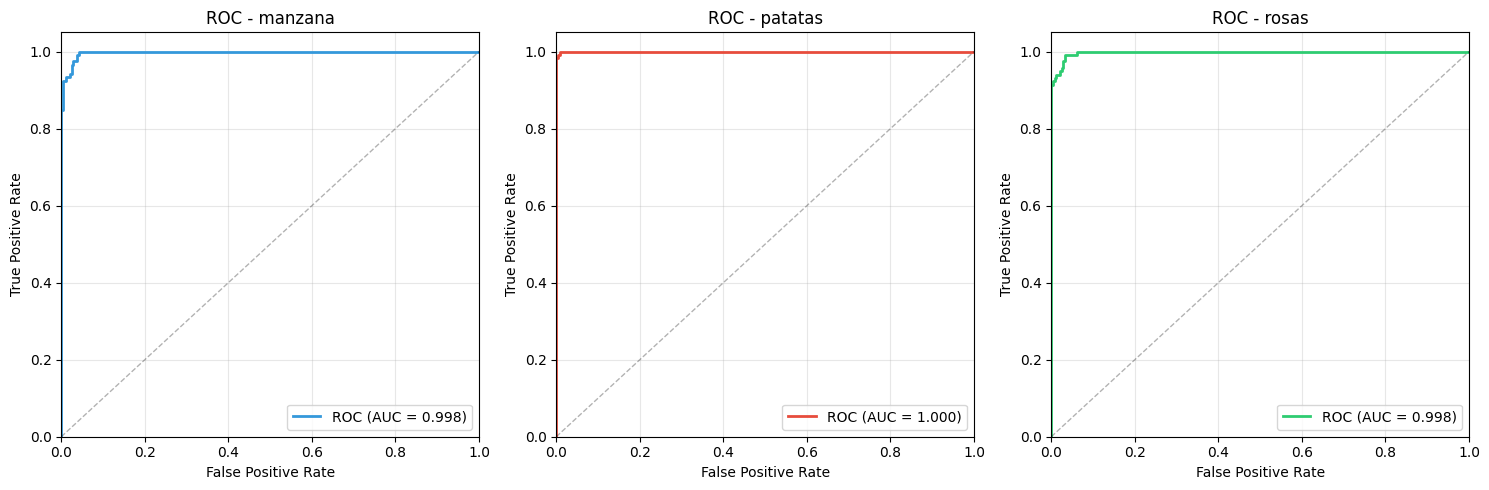

In [ ]:
y_true_bin = label_binarize(y_true, classes=[0, 1, 2])

fig, axes = plt.subplots(1, 3, figsize=(15, 5))
colors = ['#3498db', '#e74c3c', '#2ecc71']

for i, (ax, color) in enumerate(zip(axes, colors)):
    fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_prob[:, i])
    roc_auc = auc(fpr, tpr)

    ax.plot(fpr, tpr, color=color, lw=2, label=f'ROC (AUC = {roc_auc:.3f})')
    ax.plot([0, 1], [0, 1], 'k--', lw=1, alpha=0.3)
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title(f'ROC - {CLASSES[i]}')
    ax.legend(loc='lower right')
    ax.grid(alpha=0.3)

plt.tight_layout()
plt.savefig('roc_curves_mobilenet.png', dpi=150, bbox_inches='tight')
plt.show()

## Visualización 5: Distribución de Confianza

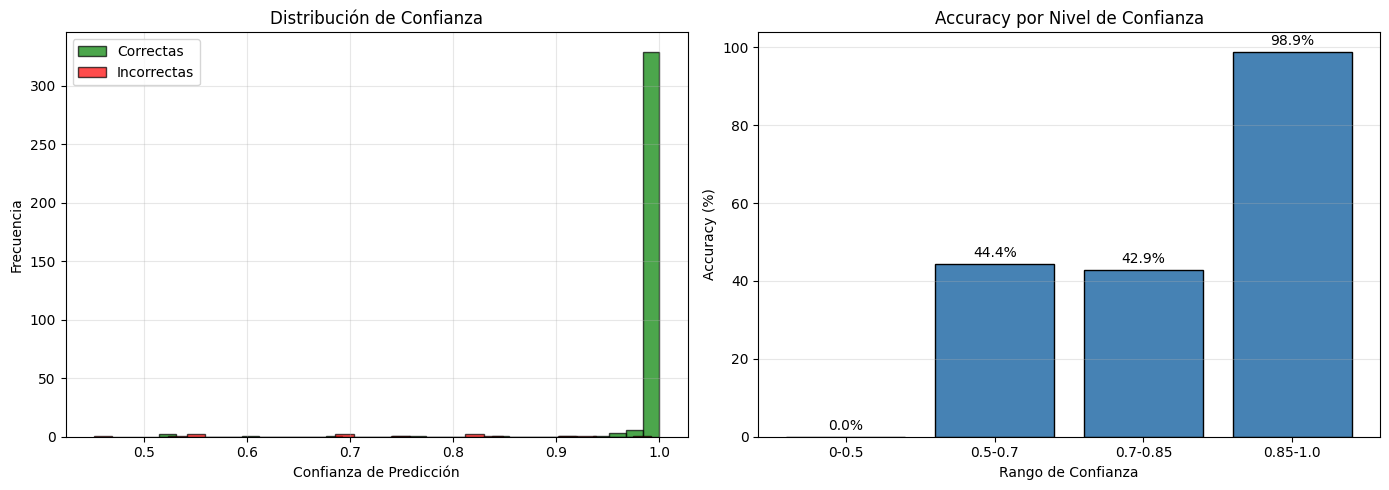

In [ ]:
max_probs = y_prob.max(axis=1)
correct_mask = (y_pred == y_true)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

ax1.hist(max_probs[correct_mask], bins=30, alpha=0.7, color='green', label='Correctas', edgecolor='black')
ax1.hist(max_probs[~correct_mask], bins=30, alpha=0.7, color='red', label='Incorrectas', edgecolor='black')
ax1.set_xlabel('Confianza de Predicción')
ax1.set_ylabel('Frecuencia')
ax1.set_title('Distribución de Confianza')
ax1.legend()
ax1.grid(alpha=0.3)

conf_ranges = [(0, 0.5), (0.5, 0.7), (0.7, 0.85), (0.85, 1.0)]
accuracies = []
for low, high in conf_ranges:
    mask = (max_probs >= low) & (max_probs < high)
    if mask.sum() > 0:
        acc = correct_mask[mask].mean()
        accuracies.append(acc * 100)
    else:
        accuracies.append(0)

ax2.bar(range(len(conf_ranges)), accuracies, color='steelblue', edgecolor='black')
ax2.set_xlabel('Rango de Confianza')
ax2.set_ylabel('Accuracy (%)')
ax2.set_title('Accuracy por Nivel de Confianza')
ax2.set_xticks(range(len(conf_ranges)))
ax2.set_xticklabels([f'{low}-{high}' for low, high in conf_ranges])
ax2.grid(axis='y', alpha=0.3)

for i, v in enumerate(accuracies):
    ax2.text(i, v + 1, f'{v:.1f}%', ha='center', va='bottom')

plt.tight_layout()
plt.savefig('confidence_distribution_mobilenet.png', dpi=150, bbox_inches='tight')
plt.show()

## Resumen de Resultados

In [ ]:
print("\n" + "="*60)
print("RESUMEN - MobileNetV3-Small")
print("="*60)

print(f"\nTest Accuracy: {test_acc:.2f}%")
print(f"Test Loss: {test_loss:.4f}")

print("\nMétricas por clase:")
for i, clase in enumerate(CLASSES):
    print(f"  {clase:12s} - P: {precision[i]:.3f} | R: {recall[i]:.3f} | F1: {f1[i]:.3f} | Support: {support[i]}")

p_macro, r_macro, f1_macro, _ = precision_recall_fscore_support(y_true, y_pred, average='macro')
p_weighted, r_weighted, f1_weighted, _ = precision_recall_fscore_support(y_true, y_pred, average='weighted')

print(f"\nMacro avg    - P: {p_macro:.3f} | R: {r_macro:.3f} | F1: {f1_macro:.3f}")
print(f"Weighted avg - P: {p_weighted:.3f} | R: {r_weighted:.3f} | F1: {f1_weighted:.3f}")

print(f"\nParámetros totales: {total_p:,}")
print(f"Tamaño del modelo: ~2.5M parámetros")


RESUMEN - MobileNetV3-Small

Test Accuracy: 96.39%
Test Loss: 0.0687

Métricas por clase:
  manzana      - P: 0.949 | R: 0.941 | F1: 0.945 | Support: 119
  patatas      - P: 0.984 | R: 1.000 | F1: 0.992 | Support: 124
  rosas        - P: 0.957 | R: 0.949 | F1: 0.953 | Support: 117

Macro avg    - P: 0.963 | R: 0.963 | F1: 0.963
Weighted avg - P: 0.964 | R: 0.964 | F1: 0.964

Parámetros totales: 1,520,931
Tamaño del modelo: ~2.5M parámetros


## Guardar Métricas

In [ ]:
import json

metrics = {
    'model': 'MobileNetV3-Small',
    'test_accuracy': test_acc,
    'test_loss': test_loss,
    'precision_macro': p_macro,
    'recall_macro': r_macro,
    'f1_macro': f1_macro,
    'per_class': {
        CLASSES[i]: {
            'precision': precision[i],
            'recall': recall[i],
            'f1': f1[i],
            'support': int(support[i])
        } for i in range(len(CLASSES))
    }
}

with open('mobilenet_metrics.json', 'w') as f:
    json.dump(metrics, f, indent=2)

print("Métricas guardadas en 'mobilenet_metrics.json'")
print("\n✓ Completado")

Métricas guardadas en 'mobilenet_metrics.json'

✓ Completado
